In [ ]:
!pip install pandas
!pip install sentence-transformers
!pip install accelerate
!pip install -U bitsandbytes!
!pip install datasets

In [5]:
import pandas as pd
df = pd.read_csv('DATASET3/final.csv')
laliste=[]
laliste_labels=[]
for elt in df['label']:
    laliste_labels.append(elt)
for elt in df['text']:
    laliste.append(elt)

In [43]:
laliste_labels=[]
for elt in train['intent']:
    laliste_labels.append(elt)

In [6]:
from sentence_transformers import SentenceTransformer
import torch

# Define arguments for 4-bit quantization
model_kwargs = {
    "device_map": "auto",         # Automatically map layers to devices (GPU/CPU)
    "torch_dtype": torch.bfloat16,  # Recommended dtype for Qwen models
    "load_in_4bit": True,           # Enable 4-bit quantization
}

# The model card also recommends enabling flash_attention_2 for better performance
# You may need to install it: pip install flash-attn
# Set use_flash_attention_2=True if available
embedding_model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-8B",
    model_kwargs=model_kwargs,
    trust_remote_code=True, # Often required for custom model architectures
    # use_flash_attention_2=True, # Uncomment if flash-attn is installed
)

/home/ubuntu/synthdata1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]


In [2]:
from datasets import load_dataset
ds = load_dataset("hrithikpiyush/acl-arc")
ds.set_format("pandas")
train=ds["train"][:]
validation=ds["validation"][:]
test=ds["test"][:]

c:\Users\chrif\Downloads\synthdata1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


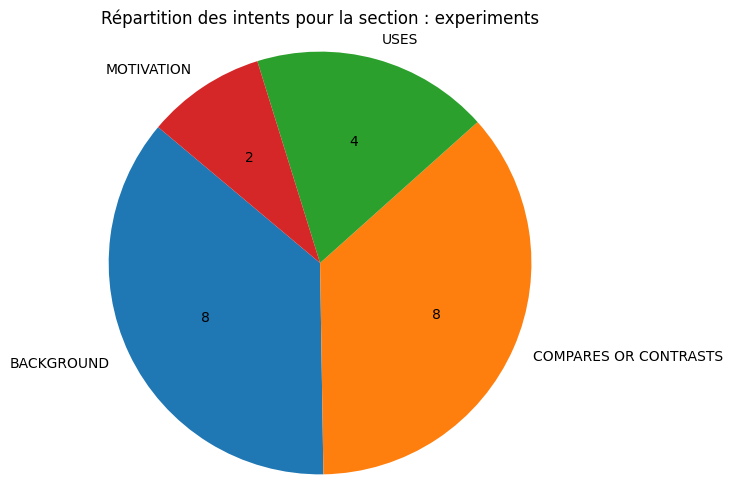

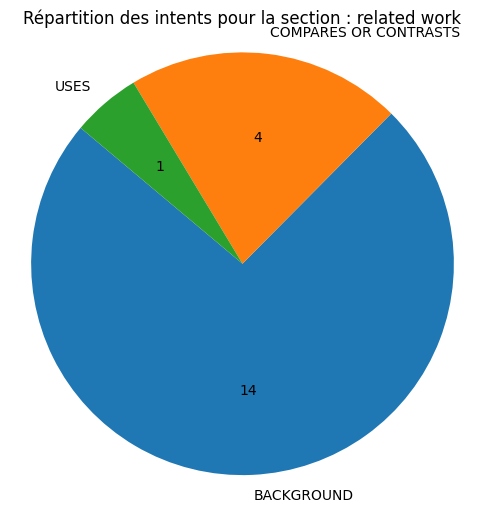

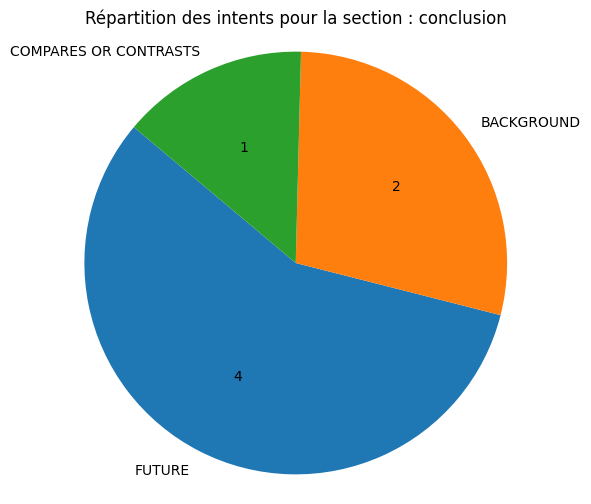

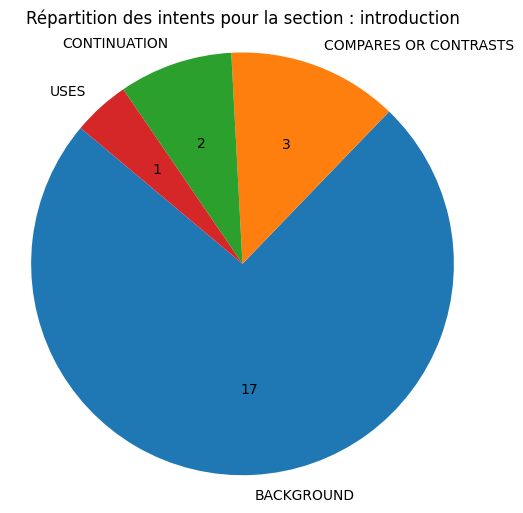

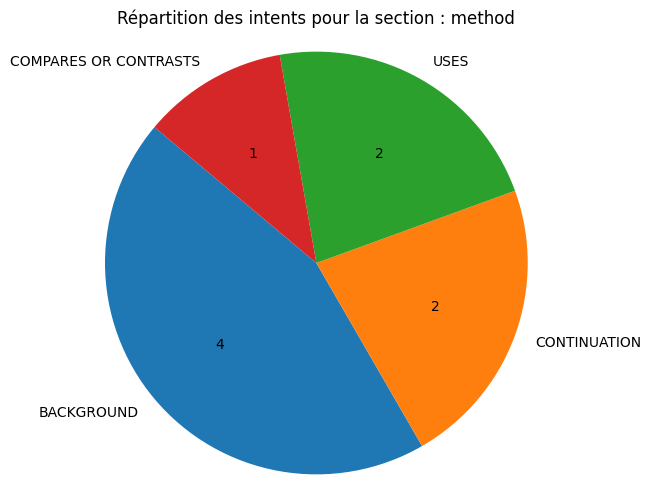

In [67]:
import matplotlib.pyplot as plt
citation_dict={
    0:"BACKGROUND",
    1:"USES",
    2:"COMPARES OR CONTRASTS",
    3:"MOTIVATION",
    4:"CONTINUATION",
    5:"FUTURE"
}
# Replace the number in test["intent"] by its name in citation_dict
test_with_names = validation.copy()
test_with_names['intent_name'] = test_with_names['intent'].map(citation_dict)

# Get unique section names (excluding None/NaN)
section_names = test_with_names['section_name'].dropna().unique()
for section in section_names:
    # Filter rows for this section
    section_df = test_with_names[test_with_names['section_name'] == section]
    # Count occurrences of each label name in this section
    label_counts = section_df['intent_name'].value_counts()
    # Plot pie chart with counts instead of percentages
    plt.figure(figsize=(6, 6))
    def absolute_value(val):
        total = sum(label_counts)
        count = int(round(val/100*total))
        return f'{count}'
    plt.pie(label_counts, labels=label_counts.index, autopct=absolute_value, startangle=140)
    plt.title(f"Répartition des intents pour la section : {section}")
    plt.axis('equal')
    plt.show()


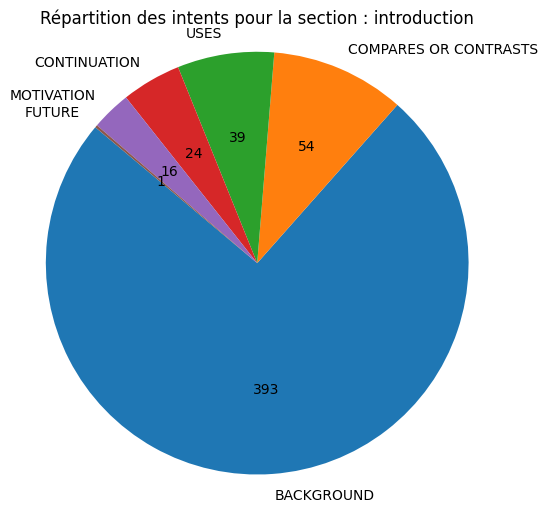

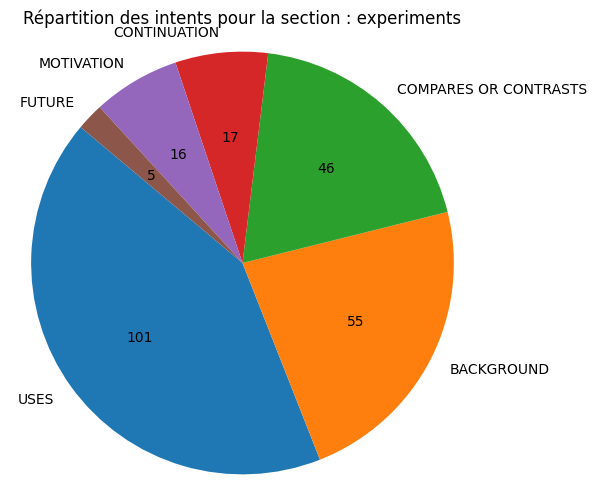

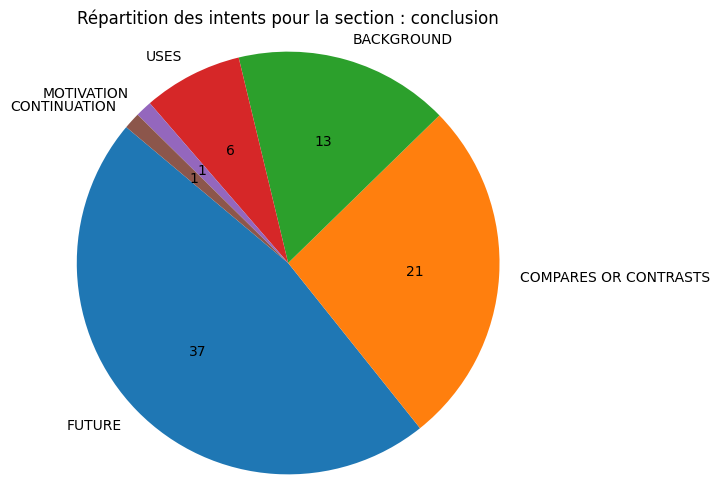

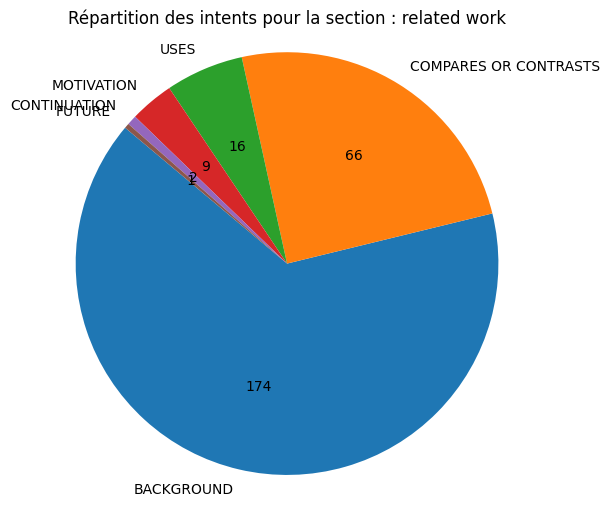

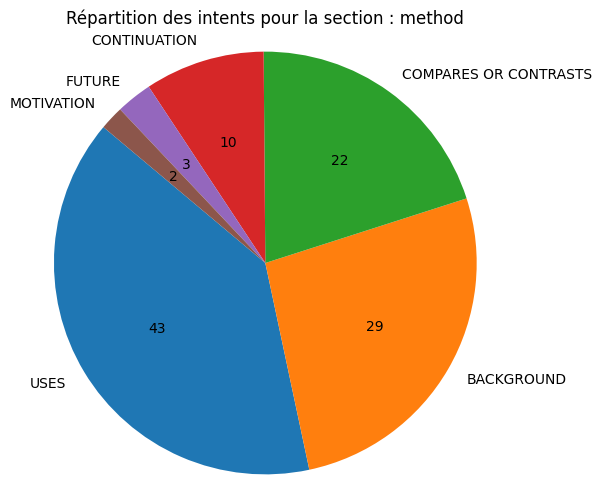

In [72]:
import matplotlib.pyplot as plt
citation_dict={
    0:"BACKGROUND",
    1:"USES",
    2:"COMPARES OR CONTRASTS",
    3:"MOTIVATION",
    4:"CONTINUATION",
    5:"FUTURE"
}
# Replace the number in train["intent"] by its name in citation_dict
train_with_names = train.copy()
train_with_names['intent_name'] = train_with_names['intent'].map(citation_dict)

# Get unique section names (excluding None/NaN)
section_names = train_with_names['section_name'].dropna().unique()
for section in section_names:
    # Filter rows for this section
    section_df = train_with_names[train_with_names['section_name'] == section]
    # Count occurrences of each label name in this section
    label_counts = section_df['intent_name'].value_counts()
    # Plot pie chart with counts instead of percentages
    plt.figure(figsize=(6, 6))
    def absolute_value(val):
        total = sum(label_counts)
        count = int(round(val/100*total))
        return f'{count}'
    plt.pie(label_counts, labels=label_counts.index, autopct=absolute_value, startangle=140)
    plt.title(f"Répartition des intents pour la section : {section}")
    plt.axis('equal')
    plt.show()


In [8]:
documents = laliste[:10]

len(documents)

10

In [12]:
documents = laliste

synth_data = torch.from_numpy(embedding_model.encode(documents))

In [27]:
# Get all unique section names (excluding None/NaN)
unique_sections = [s for s in train['section_name'].dropna().unique()]

# Create a dict mapping section name to one-hot encoded vector
section_to_onehot = {
    section: [1 if i == idx else 0 for i in range(len(unique_sections))]
    for idx, section in enumerate(unique_sections)
}

def get_section_onehot(section):
    if section is None:
        return [0, 0, 0, 0, 0]
    return section_to_onehot.get(section, [0, 0, 0, 0, 0])

get_section_onehot(None)

[0, 0, 0, 0, 0]

In [79]:
import torch
input_data = []
for elt in train['section_name'].tolist():
    input_data.append(get_section_onehot(elt))

input_data_train = torch.tensor(input_data)

input_data = []
for elt in validation['section_name'].tolist():
    input_data.append(get_section_onehot(elt))

input_data_validation = torch.tensor(input_data)

input_data = []
for elt in test['section_name'].tolist():
    input_data.append(get_section_onehot(elt))

input_data_test = torch.tensor(input_data)

In [37]:
print(input_data_train.shape)
print(input_data_validation.shape)

torch.Size([1688, 5])
torch.Size([114, 5])


In [81]:
synth_data = input_data_train
validation_data = input_data_validation
test_data = input_data_test
#test_data = torch.from_numpy(embedding_model.encode(test['section_name'].tolist()))

In [44]:
import torch

import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=10, num_classes=6):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)
mymodel = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.001)

In [45]:
from torch.utils.data import TensorDataset, DataLoader
X_train = synth_data
y_train = torch.tensor(laliste_labels)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [73]:
num_epochs = 1000

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.float()          # <-- ensure float32 inputs
        y_batch = y_batch.long()           # <-- labels as int64 for CrossEntropyLoss
        optimizer.zero_grad()
        outputs = mymodel(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()                # Update weights


In [74]:
mymodel(validation_data[4].float())

tensor([ 0.5425,  1.1634,  0.3699, -0.6880, -0.6147, -1.8586],
       grad_fn=<ViewBackward0>)

In [84]:
from sklearn.metrics import classification_report
with torch.no_grad():
    validation_outputs = mymodel(validation_data.float())
    #test_outputs = mymodel(test_data)

In [76]:
torch.argmax(validation_outputs,axis=1)

tensor([1, 0, 0, 0, 1, 0, 5, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 1, 1, 0, 1, 1, 0, 0, 0, 0, 5, 0, 1,
        0, 1, 1, 0, 0, 0, 5, 1, 0, 1, 0, 0, 0, 0, 0, 5, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0, 5, 0, 0, 0, 0, 1])

In [85]:
print(classification_report(validation['intent'], torch.argmax(validation_outputs, axis=1)))

              precision    recall  f1-score   support

           0       0.59      0.76      0.67        59
           1       0.19      0.29      0.23        21
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         5
           5       0.57      1.00      0.73         4

    accuracy                           0.48       114
   macro avg       0.23      0.34      0.27       114
weighted avg       0.36      0.48      0.41       114



c:\Users\chrif\Downloads\synthdata1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\chrif\Downloads\synthdata1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\chrif\Downloads\synthdata1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}